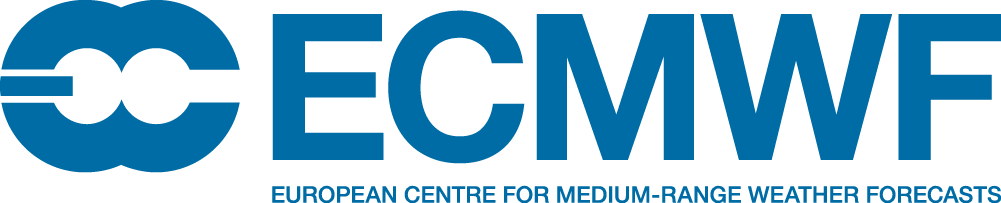
# CCSDS compression in ECMWF Real-time open data 
Authors Milana Vučković and Shahram Najm

In June 2023 ECMWF will update its IFS forecast model to version 48r1. This is a major model change with several updates which are described [here](https://confluence.ecmwf.int/display/FCST/Implementation+of+IFS+Cycle+48r1).  

With 48r1 all **gridded GRIB2 "raw"** data will use the [new CCSDS packing type](https://codes.ecmwf.int/grib/format/grib2/templates/5/42/).  
The end users will not see any change as long as they use **the latest version of ecCodes** library.

## Libraries to download and work with GRIB data

There are many tools to work with GRIB data. Here you will find how to inspect new ECMWF open data using [**ecCodes**](https://confluence.ecmwf.int/display/ECC/ecCodes+Home) Python library.  

If you are looking at this notebook on MyBinder, it should be already installed. 

If you are using this notebook individually and don't have ecCodes and [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client, please use the next cell to install them.

In [ ]:
#!pip install ecmwf-opendata eccodes

We can now import open data api client and eccodes.  
<div class="alert alert-block alert-info">
<b>Note:</b> Make sure that you have <b>ecCodes version 2.15</b> or higher for the decoding of grib data, otherwise it will not work.
</div>

In [1]:
from ecmwf.opendata import Client
from eccodes import *

version = codes_get_api_version()
print(f"Found: ecCodes v{version}")

Found: ecCodes v2.27.0


## Download data

To download test (esuite) data, set the source to '**ecmwf-esuites**'

In [2]:
client = Client("ecmwf-esuites", beta=True)

In [3]:
INPUT = "ccsds.grib2"
OUTPUT = "simple.grib2"

Test forecast is usually available a bit late, so just in case you are running this early in the morning, let's set the date parameter to yesterday.  
This is still experimental data, so if the data is not available, set the date to a few days ago.

In [4]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[850],
    param='t',
    target=INPUT
)

20230328000000-12h-oper-fc.grib2:   0%|          | 0.00/249k [00:00<?, ?B/s]

## Inspect the data
First we open the data we have just downloaded and check the packing type.

In [5]:
f = open(INPUT, "rb")

In [6]:
gid = codes_grib_new_from_file(f)
print(f'packingType = {codes_get(gid, "packingType")}')

packingType = grid_ccsds


Let's now inspect some values.

In [7]:
values_ccsds = codes_get_values(gid)
num_vals = len(values_ccsds)
for i in range(0,2000,100):
    print((i + 1, values_ccsds[i]))

(1, 252.99560546875)
(101, 252.99560546875)
(201, 252.99560546875)
(301, 252.99560546875)
(401, 252.99560546875)
(501, 252.99560546875)
(601, 252.99560546875)
(701, 252.99560546875)
(801, 252.99560546875)
(901, 253.40185546875)
(1001, 253.08935546875)
(1101, 253.18310546875)
(1201, 253.83935546875)
(1301, 254.43310546875)
(1401, 254.33935546875)
(1501, 253.58935546875)
(1601, 253.02685546875)
(1701, 253.21435546875)
(1801, 254.46435546875)
(1901, 253.65185546875)


In [8]:
print(f"{num_vals} values found in {INPUT}")

405900 values found in ccsds.grib2


We can check what happens if we convert to simple packing. It is two lines of code to convert using eccodes.

In [9]:
codes_set(gid, "packingType", "grid_simple")
codes_set_values(gid, values_ccsds)

print(f'packingType = {codes_get(gid, "packingType")}')

packingType = grid_simple


Just to make sure our values didn't change, we can print the same points again.

In [10]:
values_simple = codes_get_values(gid)
for i in range(0,2000,100):
    print((i + 1, values_simple[i]))

(1, 252.99560546875)
(101, 252.99560546875)
(201, 252.99560546875)
(301, 252.99560546875)
(401, 252.99560546875)
(501, 252.99560546875)
(601, 252.99560546875)
(701, 252.99560546875)
(801, 252.99560546875)
(901, 253.40185546875)
(1001, 253.08935546875)
(1101, 253.18310546875)
(1201, 253.83935546875)
(1301, 254.43310546875)
(1401, 254.33935546875)
(1501, 253.58935546875)
(1601, 253.02685546875)
(1701, 253.21435546875)
(1801, 254.46435546875)
(1901, 253.65185546875)


Finally we write the output into new file and close.

In [11]:
fout = open(OUTPUT, "wb")
codes_write(gid, fout)
codes_release(gid)
f.close()
fout.close()

Now we can use grib_ls to compare the two files as well.  

In [12]:
!grib_ls -j -p packingType,max,min,avg ccsds.grib2 simple.grib2

{ "messages" : [ 
  {
    "packingType": "grid_ccsds",
    "max": 304.089,
    "min": 233.558,
    "avg": 273.89
  },
  {
    "packingType": "grid_simple",
    "max": 304.089,
    "min": 233.558,
    "avg": 273.89
  }
]}


We can also compare the size of the files to see the benefit of the compression.  
In this case, the simple packed file is double the size of the CCSDS packed one

In [13]:
!ls -l *.grib2

-rw-r--r--  1 mamv  staff  254950 30 Mar 14:17 ccsds.grib2
-rw-r--r--  1 mamv  staff  609046 30 Mar 14:17 simple.grib2


If you are an advanced user, you can have a look at how to do the same things using [**Metview**](https://metview.readthedocs.io/en/latest/index.html) and [**xarray**](https://docs.xarray.dev/en/stable/) in [**this notebook**](ccsds.ipynb).